# Predicting Rainfall in Melbourne Area

## Introduction

In this project, I'll walk through my process for developing machine learning models to predict daily rainfall in the Melbourne metropolitan area. Using the "Australian Weather" dataset from Kaggle, my objective was to build and evaluate a robust **binary classification model** to accurately predict the target variable, `RainTomorrow`.

A primary challenge I identified right away was the significant **class imbalance**: there are far fewer rainy days ('Yes') than non-rainy days ('No'). To handle this, I'll be using the **Synthetic Minority Over-sampling Technique (SMOTE)**. I've integrated this directly into my `scikit-learn` pipeline to make sure I don't accidentally leak data during cross-validation.

To find the most effective solution, I decided to train, tune, and evaluate four different classification algorithms:
* Logistic Regression
* Random Forest
* XGBoost
* A Keras-based Neural Network (MLP)

I optimized all the models using `GridSearchCV`, and I specifically focused on the **F1-score**. Given the imbalanced data, F1-score is a much more reliable metric than simple accuracy. My final analysis will compare these models based on their F1-scores, ROC curves, and confusion matrices to see which algorithm is the best fit for this prediction task.

#### Importing Necessery Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)

#### Importing the Dataset

In [3]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"

In [4]:
df = pd.read_csv(url)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Handling Missing Values

A critical first step for me was addressing the missing data. During my initial exploration, I actually evaluated some advanced imputation techniques like **K-Nearest Neighbors (KNN)** and **Multiple Imputation by Chained Equations (MICE)**, but I found they led to pretty suboptimal model performance compared to a simpler approach.

Therefore, the strategy I adopted in this notebook was to simply remove all rows containing any null values. I ran `df.dropna()`, which streamlined the dataset. As you can see from the `df.info()` output in the next cell, this left me with **56,420 complete records** to work with.

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

In [6]:
city_counts = df['Location'].value_counts()
print(city_counts)

Location
Darwin              3062
Perth               3025
Brisbane            2953
MelbourneAirport    2929
PerthAirport        2913
SydneyAirport       2870
Watsonia            2730
Mildura             2594
MountGambier        2465
NorfolkIsland       2464
Cairns              2444
Townsville          2419
WaggaWagga          2416
AliceSprings        2223
Nuriootpa           2008
Hobart              1939
Moree               1913
Melbourne           1898
Portland            1863
Woomera             1734
Sydney              1690
Sale                1678
CoffsHarbour        1380
Williamtown         1198
Canberra            1078
Cobar                534
Name: count, dtype: int64


### Feature Engineering and Data Scoping

To improve my model's predictive accuracy, I made two key refinements to the data.

1.  **Regional Scoping:** The initial dataset included observations from 26 locations all across Australia (as seen in the `value_counts()` output above). Since weather patterns have high regional variance, I decided to scope my analysis to a single metropolitan area. I filtered the dataset to only keep records from `Melbourne`, `MelbourneAirport`, and `Watsonia`, as these are all in close geographic proximity. As the `df.info()` output in the next cell shows, this focused my dataset to **7,557 relevant observations**, creating a more localized and consistent sample.

2.  **Seasonality:** Rainfall is heavily influenced by seasonal patterns. To capture this, I engineered a new categorical feature, **`Season`**, from the `Date` column. As you'll see in the cells that follow, I first converted `Date` to a `datetime` object, and then I applied a function to map each record's month to 'Summer', 'Autumn', 'Winter', or 'Spring'. This will allow my models to identify how the probability of rain changes throughout the year.

In [7]:
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia'])]
df. info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

df['Season'] = df['Date'].dt.month.apply(get_season)

### Multicollinearity Analysis

To ensure the integrity of my models (especially the Logistic Regression), I performed an analysis to detect multicollinearity among the 16 numerical features. I used two standard methods:

1.  **Variance Inflation Factor (VIF):** As you'll see in the output of the next cell, the VIF scores revealed severe multicollinearity. The pressure and temperature variables had exceptionally high scores, most notably:
    * `Pressure9am` (VIF: ~333,321) and `Pressure3pm` (VIF: ~332,544)
    * `Temp3pm` (VIF: ~446) and `MaxTemp` (VIF: ~407)
    * `Temp9am` (VIF: ~156) and `MinTemp` (VIF: ~39)

2.  **Correlation Heatmap:** The `seaborn` heatmap in the cell after that visually confirmed these findings, showing near-perfect positive correlations (1.00) between `Pressure9am` and `Pressure3pm`, and a very strong correlation (0.98) between `MaxTemp` and `Temp3pm`.

Despite this high multicollinearity, my preliminary experiments showed that trying to combine or remove these features didn't actually improve model performance. This is likely because the modeling techniques I chose are inherently robust to this issue:

* **Tree-Based Models (Random Forest & XGBoost):** These models aren't significantly impacted by multicollinearity because their decision-tree splitting mechanism considers features one by one.
* **Regularized Logistic Regression:** My `GridSearchCV` (which you'll see later) for Logistic Regression tests for `penalty='l2'`. This L2 regularization effectively mitigates the impact of multicollinearity by shrinking the coefficients of correlated variables.

Given this, I decided to retain all numerical features for my preprocessing pipeline.

In [10]:
numerical_features_df = df.select_dtypes(include=['float64', 'int64'])

vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_features_df.columns
vif_data['VIF'] = [variance_inflation_factor(numerical_features_df.values, i) for i in range(numerical_features_df.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))

          Feature            VIF
10    Pressure9am  333320.921320
11    Pressure3pm  332544.154474
15        Temp3pm     445.851761
1         MaxTemp     406.935291
14        Temp9am     155.656671
8     Humidity9am      80.076617
9     Humidity3pm      50.187575
0         MinTemp      38.693852
5   WindGustSpeed      28.392348
7    WindSpeed3pm      13.916090
4        Sunshine      13.522279
13       Cloud3pm      11.744636
12       Cloud9am       8.927730
6    WindSpeed9am       8.301341
3     Evaporation       7.408197
2        Rainfall       1.311646


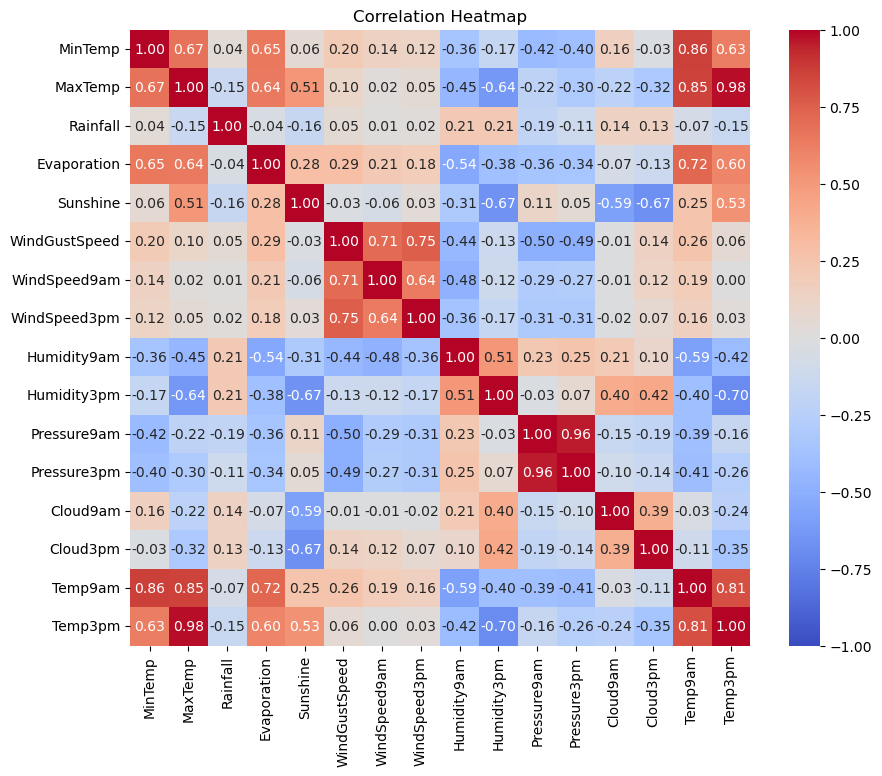

In [11]:
corr_matrix = numerical_features_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,     
    cmap='coolwarm',
    fmt='.2f',      
    vmin=-1,        
    vmax=1         
)
plt.title('Correlation Heatmap')
plt.show()

### Data preparation for the machine learning workflow

First, I defined my feature matrix `X` in the next cell by dropping the target variable (`RainTomorrow`) and the original `Date` column.

In [12]:
X = df.drop(['Date', 'RainTomorrow'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       7557 non-null   object 
 1   MinTemp        7557 non-null   float64
 2   MaxTemp        7557 non-null   float64
 3   Rainfall       7557 non-null   float64
 4   Evaporation    7557 non-null   float64
 5   Sunshine       7557 non-null   float64
 6   WindGustDir    7557 non-null   object 
 7   WindGustSpeed  7557 non-null   float64
 8   WindDir9am     7557 non-null   object 
 9   WindDir3pm     7557 non-null   object 
 10  WindSpeed9am   7557 non-null   float64
 11  WindSpeed3pm   7557 non-null   float64
 12  Humidity9am    7557 non-null   float64
 13  Humidity3pm    7557 non-null   float64
 14  Pressure9am    7557 non-null   float64
 15  Pressure3pm    7557 non-null   float64
 16  Cloud9am       7557 non-null   float64
 17  Cloud3pm       7557 non-null   float64
 18  Temp9am 

Next, in the following cell, I created my target vector `y` by mapping the categorical 'No'/'Yes' labels to a binary `0`/`1` format. The output of `y.value_counts()` confirms the significant class imbalance I mentioned earlier (**76.3% 'No' vs. 23.7% 'Yes'**).

In [13]:
y = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
y.value_counts()

RainTomorrow
0    5766
1    1791
Name: count, dtype: int64

In the next cell, I'm preparing for the preprocessing pipeline by programmatically identifying and storing the names of all numerical and categorical features into separate lists.

In [14]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

Finally, in the next cell, I'm using `train_test_split` to divide `X` and `y` into training and testing sets, holding back 25% of the data for the final evaluation. It's important to note that I'm using **`stratify=y`** to ensure this class imbalance is preserved in both the training and test splits.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

### Cross-Validation Strategy

For my cross-validation strategy, I've used `StratifiedKFold`. This will define the method that `GridSearchCV` uses in the subsequent steps to evaluate different model hyperparameters.

The selection of `StratifiedKFold` is a crucial decision for this project. Given the significant **class imbalance** (76.3% 'No' vs 23.7% 'Yes') that I confirmed in the output above, a standard K-fold cross-validation could lead to folds that don't accurately represent the minority class, which would skew my performance metrics.

`StratifiedKFold` prevents this by ensuring that each of the 5 folds (`n_splits=5`) preserves the original 76/24 percentage split. This guarantees that each validation fold is a realistic and representative sample of the overall training data.

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Feature Preprocessing Pipeline

For my data preprocessing architecture, I'm using `scikit-learn`'s `Pipeline` and `ColumnTransformer`. This structure is essential for applying different transformations to my numerical and categorical data subsets systematically and, most importantly, for preventing data leakage when I use it within `GridSearchCV` later.

In the next cell, I construct this preprocessing pipeline in three parts:

1.  **`numeric_transformer`:** This is a `Pipeline` I created to process all 16 features I identified as `numeric_features`. It has one step:
    * **`('scaler', StandardScaler())`:** This scales all numerical data (removes mean, scales to unit variance). This standardization is critical for the performance of models like **Logistic Regression** and **Neural Networks**.

2.  **`categorical_transformer`:** This pipeline handles the 6 `categorical_features`. Its single step is:
    * **`('onehot', OneHotEncoder(handle_unknown='ignore'))`:** This converts categorical strings (like 'Melbourne' or 'Winter') into binary "dummy" columns. I set `handle_unknown='ignore'` to prevent the model from erroring if it sees a new category in the test set.

3.  **`preprocessor` (`ColumnTransformer`):** This is the final object that combines the two specialized pipelines. It directs the `numeric_transformer` to *only* the `numeric_features` and the `categorical_transformer` to *only* the `categorical_features`.

In [17]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### Model 1: Logistic Regression

The next cell defines and executes my complete training and hyperparameter tuning workflow for the first model: **Logistic Regression**. I've set this up as a robust, end-to-end process that correctly handles preprocessing, class imbalance, and model optimization all at once.

Here's how I structured it:

1.  **`Pipeline` (`pipe_lr`):** I created a `scikit-learn` `Pipeline` to chain all the steps. This is critical for preventing data leakage. The pipeline consists of:
    * **('preprocessor', `preprocessor`):** First, it applies the `ColumnTransformer` (from the previous cell) to scale and one-hot encode the features.
    * **('smote', `SMOTE(...)`):** Second, it applies **SMOTE**. By placing SMOTE *inside* the pipeline, I ensure that oversampling is only performed on the training data *within each fold* of the cross-validation, not on the validation or test data. This is the correct way to handle imbalance without biasing the evaluation.
    * **('model', `LogisticRegression(...)`):** The final step is the classifier. I set `max_iter=1000` to make sure the solver has enough iterations to converge.

2.  **Parameter Grid (`param_grid_lr`):** This is the dictionary of hyperparameters I want `GridSearchCV` to test:
    * `model__C`: The inverse of regularization strength (testing `0.01` to `10`).
    * `model__penalty`: Using 'l2' (Ridge) regularization, which I chose to handle the multicollinearity I found earlier.
    * `model__solver`: Using 'lbfgs'.

3.  **Grid Search (`GridSearchCV`):** I'm passing the pipeline and parameter grid into `GridSearchCV`, configured with:
    * `cv=cv`: This uses the 5-fold `StratifiedKFold` object I created earlier.
    * `scoring='f1'`: This is a crucial choice. It tells the grid search to optimize for the **F1-score**, which is a much more reliable metric than accuracy for my imbalanced problem.
    * `n_jobs=-1`: This tells it to use all my CPU cores to speed up the tuning.

Finally, I call `grid_lr.fit()`, which runs the search on `X_train` and `y_train`. The cell will print the best parameters it found and the resulting mean cross-validated F1-score.

In [18]:
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000))
])

param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=cv, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best Parameters (Logistic Regression):", grid_lr.best_params_)
print("Best Cross-validation Score:", grid_lr.best_score_)

Best Parameters (Logistic Regression): {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best Cross-validation Score: 0.6339996549966496


  File "C:\Users\1iCE\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\1iCE\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\1iCE\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\1iCE\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Now I'll take the best-performing Logistic Regression pipeline found by the grid search, use it to preprocess my unseen test data (`X_test`), and generate the final binary predictions, which I'll store in `y_pred`.

In [19]:
y_pred = grid_lr.best_estimator_.predict(X_test)

### Analysis of Logistic Regression Performance

The evaluation metrics from my test set provide a clear picture of how my tuned Logistic Regression model behaves, especially with the imbalanced data.

* **Overall Metrics:** The model achieved an **F1-score of 0.618** and an overall **accuracy of 0.780**. While 78% accuracy looks high, it's a misleading metric here. The F1-score (which I optimized for) gives a much more reliable measure.

* **Class-Specific Performance (from Classification Report):**
    * **Class 1 (Yes - Rain):** This is the minority class, my primary focus. The model produced an excellent **recall of 0.75**. This tells me that using **SMOTE** in the pipeline was highly effective, as the model correctly identified **75% of all actual rainy days** in the test set.
    * However, this high recall came at a significant cost: **precision was only 0.53**. This means that when my model predicted rain, it was only correct 53% of the time. The confusion matrix confirms this trade-off: it correctly found 336 rainy days (True Positives) but also incorrectly predicted rain on 303 non-rainy days (False Positives).
    * **Class 0 (No - No Rain):** As I expected, the model performed very well on the majority class, with high **precision (0.91)** and good **recall (0.79)**.

* **My Conclusion:** My tuned Logistic Regression model is highly **sensitive** but not very **precise**. It's well-optimized to *catch* a high percentage of rain events, but it does so by generating a lot of false alarms.

In [20]:
acc_lr = accuracy_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred)
cfm_lr = confusion_matrix(y_test, y_pred)
cfr = classification_report(y_test, y_pred)

print("Accuracy:", acc_lr)
print("F1-score:", f1_lr)
print("Confusion Matrix:\n", cfm_lr)
print("\nClassification Report:\n", cfr)

Accuracy: 0.7804232804232805
F1-score: 0.6182152713891444
Confusion Matrix:
 [[1139  303]
 [ 112  336]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.79      0.85      1442
           1       0.53      0.75      0.62       448

    accuracy                           0.78      1890
   macro avg       0.72      0.77      0.73      1890
weighted avg       0.82      0.78      0.79      1890



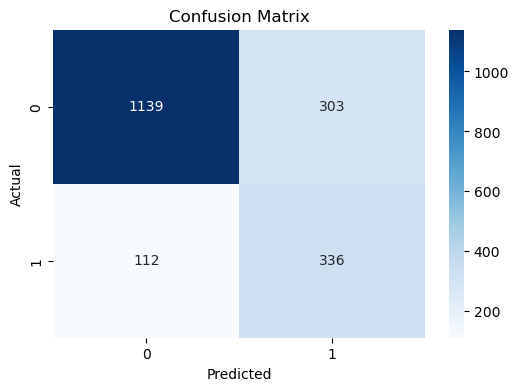

In [21]:
plt.figure(figsize=(6,4))
sns.heatmap(cfm_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model 2: Random Forest

The next cell mirrors the robust workflow I established for Logistic Regression but adapts it for a **Random Forest Classifier**.

1.  **`Pipeline` (`pipe_rf`):** I'm constructing a new pipeline, again integrating all the key steps:
    * **('preprocessor', `preprocessor`):** Applies the `StandardScaler` and `OneHotEncoder`.
    * **('smote', `SMOTE(...)`):** Includes SMOTE to oversample the minority class during training.
    * **('model', `RandomForestClassifier(...)`):** The classifier itself.

2.  **Parameter Grid (`param_grid_rf`):** I defined a grid of hyperparameters specific to Random Forest for tuning:
    * `model__n_estimators`: The number of trees (testing `[100, 200]`).
    * `model__max_depth`: The max depth (testing `[5, 10, None]`).
    * `model__min_samples_split`: Min samples to split a node (testing `[2, 5]`).

3.  **Grid Search (`GridSearchCV`):** I'm instantiating `GridSearchCV` to automate this. It will use the `pipe_rf` pipeline, search the `param_grid_rf`, and use my 5-fold **`StratifiedKFold`** (`cv`). Again, I'm using **`scoring='f1'`** to optimize for the imbalanced dataset and `n_jobs=-1` to speed things up.

`grid_rf.fit()` will kick off the training, and the cell will print the best parameters and the best F1-score.

In [22]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=cv, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best Parameters (Random Forest):", grid_rf.best_params_)
print("Best Cross-validation Score:", grid_rf.best_score_)

Best Parameters (Random Forest): {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best Cross-validation Score: 0.665398507240772


Now I'll take the best-performing Random Forest pipeline, use it to predict on `X_test`, and store the results in `y_pred`.

In [23]:
y_pred = grid_rf.best_estimator_.predict(X_test)

### Analysis of Random Forest Performance

These evaluation metrics show that my tuned **Random Forest** model provides a very strong and well-rounded performance.

* **Overall Metrics:** The model achieved a high **F1-score of 0.652** and an **accuracy of 0.836**. That F1-score is a solid improvement over the Logistic Regression.

* **Class-Specific Performance (from Classification Report):**
    * **Class 1 (Yes - Rain):** The model performed really well on the minority (rain) class, achieving an **F1-score of 0.65**. This was driven by a strong and, importantly, *balanced* **precision (0.66)** and **recall (0.65)**.
    * This balance is a key finding for me. It shows the model is much more reliable than the Logistic Regression: when it predicts rain, it's correct 66% of the time, and it successfully identifies 65% of all actual rain events.
    * The confusion matrix supports this: I got 290 True Positives, with only 152 False Positives (false alarms) and 158 False Negatives (missed rain days). This is a much more practical and balanced outcome.
    * **Class 0 (No - No Rain):** The model is still extremely strong at identifying non-rainy days (0.89 precision/recall).

* **My Conclusion:** The tuned Random Forest is a strong classifier for this problem. It achieves a good F1-score by effectively balancing the precision/recall trade-off, making it a reliable and practical solution.

In [24]:
acc_rf = accuracy_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
cfm_rf = confusion_matrix(y_test, y_pred)
cfr_rf = classification_report(y_test, y_pred)

print("Accuracy:", acc_rf)
print("F1-score:", f1_rf)
print("Confusion Matrix:\n", cfm_rf)
print("\nClassification Report:\n", cfr_rf)

Accuracy: 0.8359788359788359
F1-score: 0.651685393258427
Confusion Matrix:
 [[1290  152]
 [ 158  290]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1442
           1       0.66      0.65      0.65       448

    accuracy                           0.84      1890
   macro avg       0.77      0.77      0.77      1890
weighted avg       0.84      0.84      0.84      1890



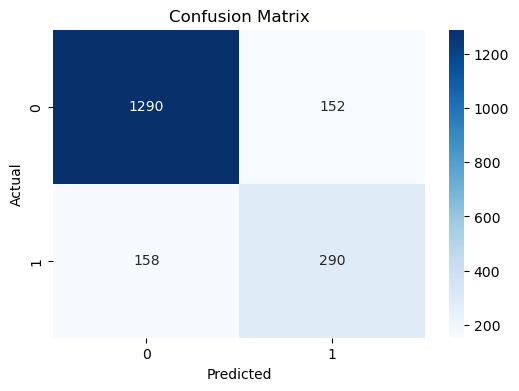

In [25]:
plt.figure(figsize=(6,4))
sns.heatmap(cfm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model 3: XGBoost

In the next cell, I'm constructing and training my third model, an **XGBoost (Extreme Gradient Boosting) Classifier**. I'm using the same pipeline and `GridSearchCV` framework to ensure a fair and rigorous comparison.

1.  **`Pipeline` (`pipe_xgb`):**
    * **('preprocessor', `preprocessor`):** The standard preprocessing step.
    * **('smote', `SMOTE(...)`):** The SMOTE oversampler.
    * **('model', `XGBClassifier(...)`):** The XGBoost model. I set `eval_metric='logloss'` for its internal operations.

2.  **Parameter Grid (`param_grid_xgb`):** I'm defining a comprehensive grid to tune the XGBoost model:
    * `model__n_estimators`: Number of trees (100, 200).
    * `model__max_depth`: Max depth (3, 5, 7).
    * `model__learning_rate`: Step size shrinkage (0.01, 0.1) to prevent overfitting.
    * `model__subsample`: Fraction of training samples (0.8, 1.0).

3.  **Grid Search (`GridSearchCV`):** Again, I'm configuring this to use the `StratifiedKFold` (`cv`) and optimize for the **`f1` score** using all my CPU cores (`n_jobs=-1`).

The `grid_xgb.fit()` command will run this search, and the output will show the best parameters and the best cross-validated F1-score.

In [26]:
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(
        eval_metric='logloss',
        random_state=42
    ))
])

param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=cv, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best Parameters (XGBoost):", grid_xgb.best_params_)
print("Best Cross-validation Score:", grid_xgb.best_score_)

Best Parameters (XGBoost): {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 0.8}
Best Cross-validation Score: 0.6635488321024571


Now I'll take the best-performing XGBoost pipeline, use it to predict on `X_test`, and store the results in `y_pred`.

In [27]:
y_pred = grid_xgb.best_estimator_.predict(X_test)

### Analysis of XGBoost Performance

These evaluation metrics indicate that my tuned **XGBoost Classifier** is a highly effective and well-balanced model.

* **Overall Metrics:** The model achieved an **F1-score of 0.660** (rounded from 0.6596) and an **accuracy of 0.846**. This F1-score is the best one so far, which is a great result.

* **Class-Specific Performance (from Classification Report):**
    * **Class 1 (Yes - Rain):** The model shows excellent performance on the minority (rain) class, with an **F1-score of 0.66**. This is supported by a strong **precision of 0.69** and a solid **recall of 0.63**.
    * This balance is its key strength. A precision of 0.69 means when it predicts rain, it's correct 69% of the time, and a recall of 0.63 means it still caught 63% of all actual rain events.
    * The confusion matrix confirms this: it has a very good ratio of True Positives (282) to False Positives (125), showing it doesn't "over-predict" rain to get its recall.
    * **Class 0 (No - No Rain):** The model is extremely reliable at identifying non-rainy days (0.89 precision / 0.91 recall).

* **My Conclusion:** The tuned XGBoost model is a high-performing and practical classifier. It delivered the best balance of precision and recall for the minority class, making it both accurate in its positive predictions and effective at capturing most rain events.

In [28]:
acc_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
cfm_xgb = confusion_matrix(y_test, y_pred)
cfr_xgb = classification_report(y_test, y_pred)

print("Accuracy:", acc_xgb)
print("F1-score:", f1_xgb)
print("Confusion Matrix:\n", cfm_xgb)
print("\nClassification Report:\n", cfr_xgb)

Accuracy: 0.846031746031746
F1-score: 0.6596491228070176
Confusion Matrix:
 [[1317  125]
 [ 166  282]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1442
           1       0.69      0.63      0.66       448

    accuracy                           0.85      1890
   macro avg       0.79      0.77      0.78      1890
weighted avg       0.84      0.85      0.84      1890



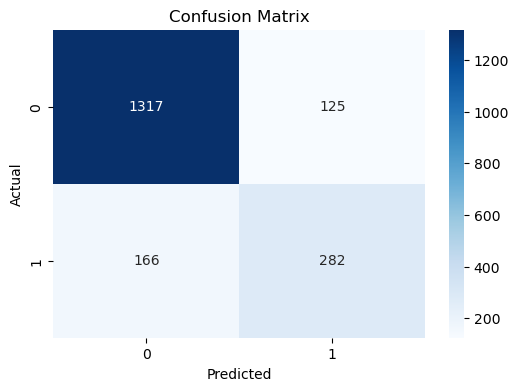

In [29]:
plt.figure(figsize=(6,4))
sns.heatmap(cfm_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model 4: Keras Neural Network

This section details my setup and execution for the final and most complex model, a Keras-based Neural Network. I'm breaking it into two parts: defining the model architecture and then preparing and executing the training pipeline.

#### Function Definition

The next cell defines a function, `create_keras_model`, that builds and compiles a **Keras Sequential Neural Network**. I'm using a function-based approach to make the Keras model compatible with the `KerasClassifier` wrapper and, subsequently, my `scikit-learn` `GridSearchCV` and `Pipeline` ecosystem.

I designed the function to be flexible, accepting hyperparameters as arguments (`hidden_units`, `dropout_rate`, `optimizer`) which I'll be tuning in the grid search.

The model architecture itself is a **Multi-Layer Perceptron (MLP)**:

1.  **Input Layer:** An `Input` layer defined to accept a 1D vector of `input_dim` features. (I'll calculate this `input_dim` value in the next step; it's the total number of features *after* my `ColumnTransformer` is applied).
2.  **Hidden Layers:** Two hidden `Dense` layers with `relu` activation.
3.  **Dropout:** I'm applying `Dropout` layers after each hidden layer as a regularization technique to prevent overfitting. The dropout rate is also tunable.
4.  **Output Layer:** The final `Dense` layer has **one neuron** and uses a **`sigmoid` activation function**—the standard for a binary classification problem, as it outputs a probability between 0 and 1.
5.  **Compilation:** I'm compiling the model with:
    * **`loss='binary_crossentropy'`**: The correct loss function for a binary (Yes/No) task.
    * **`optimizer=optimizer`**: This allows me to tune the optimizer ('adam' or 'rmsprop').
    * **`metrics=['accuracy']`**: So the model reports accuracy during training.

This function serves as the blueprint that `GridSearchCV` will use to create and test multiple versions of my neural network.

#### Pipeline and Execution

**Cell 30: Pipeline and Grid Definition**

1.  **Input Dimension Calculation:** A Keras model needs a fixed input shape. To get this, I fit my `preprocessor` on `X_train` one time to create `X_train_processed`. The resulting number of columns (`.shape[1]`) is saved as the `input_dim` variable. I then pass this to the `KerasClassifier` wrapper so it knows the exact input shape to build.

2.  **`Pipeline` (`pipe_nn`):** I'm defining a new pipeline with the same robust structure:
    * `('preprocessor', preprocessor)`: The standard preprocessing step.
    * `('smote', SMOTE(...))`: The SMOTE oversampler.
    * `('model', KerasClassifier(...))`: This is the wrapper that makes my Keras model (`create_keras_model`) compatible with `scikit-learn`. I'm initializing it with the `input_dim` and setting `verbose=0` to silence the epoch training logs during the grid search.

3.  **Parameter Grid (`param_grid_nn`):** I'm defining a grid to tune the network's architecture and training process:
    * **Model Architecture:** `model__hidden_units` and `model__dropout_rate`.
    * **Training Parameters:** `model__optimizer`, `model__epochs`, and `model__batch_size`.

**Cell 31: Model Training and Execution**

1.  **`GridSearchCV` Instantiation:** I'm creating the `GridSearchCV` object, bringing all the components together: the pipeline (`pipe_nn`), the parameter grid (`param_grid_nn`), my 5-fold stratified validator (`cv`), and the `scoring='f1'` metric.

2.  **Execution (`grid_nn.fit()`):** This command begins the intensive training process. For *each combination* of parameters, `GridSearchCV` will perform the following steps 5 times (one for each CV fold):
    1.  Split the training data.
    2.  Apply the `preprocessor` and `SMOTE`.
    3.  Build a new Keras model with the specified hyperparameters.
    4.  Train that model for the specified `epochs` and `batch_size`.
    5.  Evaluate its F1-score on the validation fold.

3.  **Output:** Finally, the cell will print the best-performing set of hyperparameters and the highest mean F1-score.

In [30]:
def create_keras_model(input_dim, hidden_units=64, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate / 2))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [31]:
X_train_processe = preprocessor.fit_transform(X_train)
input_dim = X_train_processe.shape[1]

pipe_nn = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', KerasClassifier(
        model=create_keras_model,
        input_dim=input_dim,
        verbose=0,
        hidden_units=64,
        dropout_rate=0.5,
        optimizer='adam')
    )
])

param_grid_nn = {
    'model__hidden_units': [32, 64],
    'model__dropout_rate': [0.3, 0.5],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__epochs': [50, 100],
    'model__batch_size': [32, 64]
}

In [32]:
grid_nn = GridSearchCV(pipe_nn, param_grid_nn, cv=cv, scoring='f1', n_jobs=-1)
grid_nn.fit(X_train, y_train)

print("Best Parameters (Neural Network):", grid_nn.best_params_)
print("Best Cross-validation Score:", grid_nn.best_score_)

Best Parameters (Neural Network): {'model__batch_size': 64, 'model__dropout_rate': 0.5, 'model__epochs': 50, 'model__hidden_units': 64, 'model__optimizer': 'rmsprop'}
Best Cross-validation Score: 0.6580078533455512


Now I'll take the best-performing Neural Network pipeline, use it to predict on `X_test`, and store the results in `y_pred`.

In [33]:
y_pred = grid_nn.best_estimator_.predict(X_test)

### Analysis of Keras Neural Network Performance

The evaluation metrics from the test set for my tuned Keras Neural Network (MLP) show a model that is highly sensitive but lacks precision—a behavior I also saw in my Logistic Regression model, which was strongly influenced by the SMOTE-balanced training.

* **Overall Metrics:** The model achieved a final test **F1-score of 0.641** (rounded from 0.6406) and an **accuracy of 0.810**. The F1-score is my key metric here.

* **Class-Specific Performance (from Classification Report):** The model's behavior is clearly defined by the precision/recall trade-off for the minority class (Class 1: 'Yes - Rain').
    * **High Recall (0.71):** The model successfully identified **71% of all actual rainy days**. This shows the SMOTE-balanced training was effective in making the model highly sensitive.
    * **Low Precision (0.58):** This high sensitivity came at a cost to precision. When my model predicted rain, it was only correct 58% of the time.

* **Confusion Matrix Analysis:** The matrix quantifies this. I got 320 True Positives (correctly predicted rain) but also 231 False Positives (false alarms). It successfully avoided a high number of False Negatives (only 128 missed rain days).

* **My Conclusion:** My Keras Neural Network, much like the Logistic Regression model, is optimized to be highly **sensitive**. It's good at *catching* rain events but generates a significant number of false alarms. This high-recall, lower-precision profile makes it less balanced than the tree-based methods I evaluated.

In [34]:
acc_nn = accuracy_score(y_test, y_pred)
f1_nn = f1_score(y_test, y_pred)
cfm_nn = confusion_matrix(y_test, y_pred)
cfr_nn = classification_report(y_test, y_pred)

print("Accuracy:", acc_nn)
print("F1-score:", f1_nn)
print("Confusion Matrix:\n", cfm_nn)
print("\nClassification Report:\n", cfr_nn)

Accuracy: 0.81005291005291
F1-score: 0.6406406406406406
Confusion Matrix:
 [[1211  231]
 [ 128  320]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87      1442
           1       0.58      0.71      0.64       448

    accuracy                           0.81      1890
   macro avg       0.74      0.78      0.76      1890
weighted avg       0.83      0.81      0.82      1890



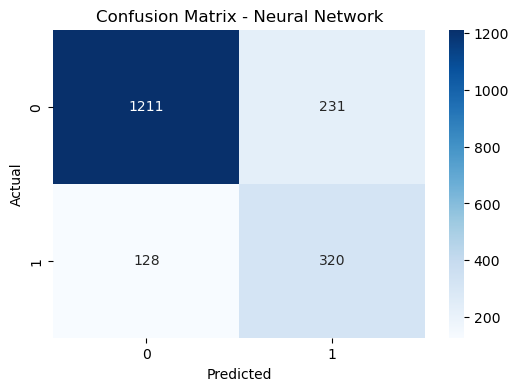

In [35]:
plt.figure(figsize=(6,4))
sns.heatmap(cfm_nn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()

I'll consolidate the test set performance metrics from all four models (Logistic Regression, Random Forest, XGBoost, and Keras) into a single `pandas` DataFrame. I'll then print this DataFrame, sorting it by 'F1-score' in descending order, to get a clear, side-by-side comparison and definitively identify which model performed best.

In [36]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network (Keras)'],
    'Accuracy': [acc_lr, acc_rf, acc_xgb, acc_nn],
    'F1-score': [f1_lr, f1_rf, f1_xgb, f1_nn]
})

print("Model Comparison:")
print(results.sort_values(by='F1-score', ascending=False))

Model Comparison:
                    Model  Accuracy  F1-score
2                 XGBoost  0.846032  0.659649
1           Random Forest  0.835979  0.651685
3  Neural Network (Keras)  0.810053  0.640641
0     Logistic Regression  0.780423  0.618215


I'm taking the `results` DataFrame, which contains the 'Accuracy' and 'F1-score' for all four of my models, and plotting them as a grouped bar chart for a quick visual comparison. I'm sorting the models by 'F1-score' so the best-performing model appears first. I'm also customizing the plot to add a title, labels, and annotations for each bar with its precise score (e.g., "0.660") to make the results easy to interpret.

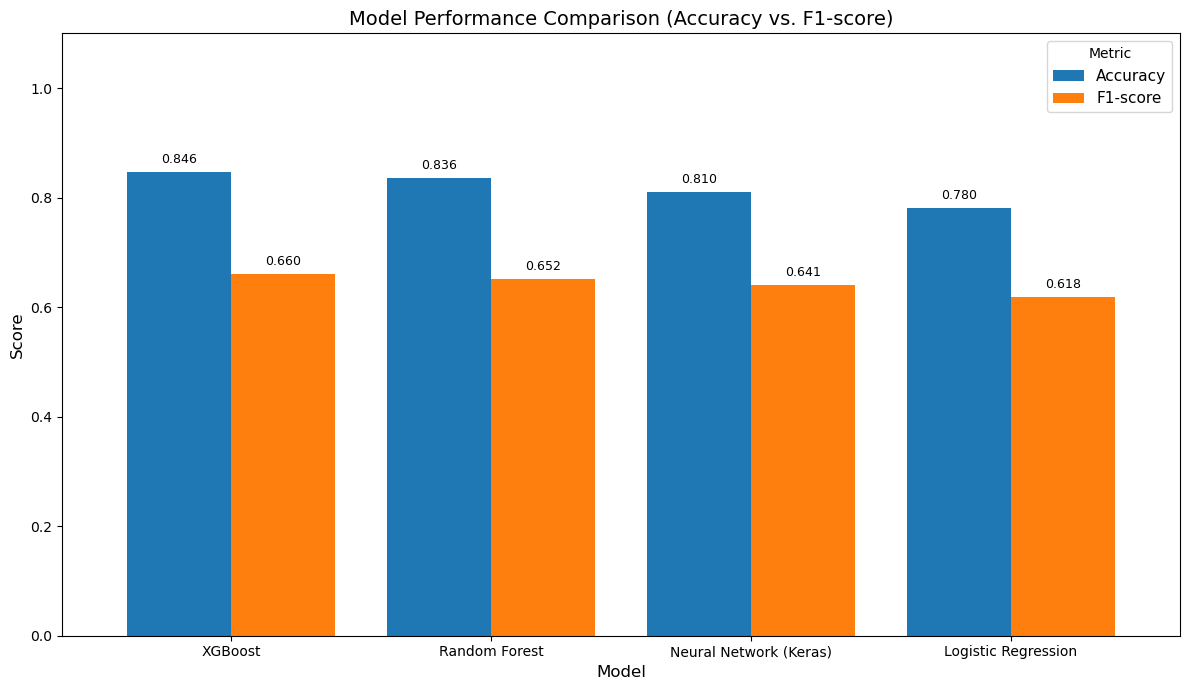

In [37]:
results_plot = results.set_index('Model')

results_plot = results_plot.sort_values(by='F1-score', ascending=False)

ax = results_plot.plot(
    kind='bar', 
    figsize=(12, 7), 
    rot=0,
    width=0.8
)

ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Model Performance Comparison (Accuracy vs. F1-score)', fontsize=14)
ax.legend(title='Metric', fontsize=11)
ax.set_ylim(0, 1.1)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=9
    )

plt.tight_layout()
plt.show()

### Model Performance Comparison

This bar chart provides a clear, visual summary of the final performance metrics for all four of my tuned models on the unseen test data.

My findings from this visualization are:

1.  **Best Overall Model:** The **XGBoost Classifier** is the top-performing model for this task.

2.  **Performance by F1-Score (My Key Metric):**
    Since this is an imbalanced dataset, the **F1-score** (orange bar) is the most important metric for me.
    * **XGBoost** achieved the highest F1-score at **0.660**.
    * **Random Forest** was a very close second with an F1-score of **0.652**.
    * The **Neural Network** came in third at **0.641**.
    * **Logistic Regression** had the lowest F1-score at **0.618**.

3.  **The Accuracy vs. F1-Score Gap:** The chart vividly illustrates the impact of the class imbalance. For every model, there is a significant gap between its high **Accuracy** (blue bar) and its more modest **F1-score**. This is expected; the high accuracy (e.g., 0.846 for XGBoost) is inflated by the model's ability to correctly predict the majority "No Rain" class. The F1-score gives me a more realistic measure of how well the models did at the much harder task of correctly identifying the minority "Yes - Rain" class.

4.  **Model Tiers:** My results show two distinct performance tiers:
    * **Tier 1 (Tree-Based Ensembles):** XGBoost and Random Forest both proved highly effective.
    * **Tier 2 (Linear/Neural Network):** The Keras Neural Network and Logistic Regression models were less successful at balancing precision and recall, resulting in lower (though still decent) F1-scores.

In [38]:
best_model_lr = grid_lr.best_estimator_
best_model_rf = grid_rf.best_estimator_
best_model_xgb = grid_xgb.best_estimator_
best_model_nn = grid_nn.best_estimator_

y_pred_probs_lr = best_model_lr.predict_proba(X_test)[:, 1]
y_pred_probs_rf = best_model_rf.predict_proba(X_test)[:, 1]
y_pred_probs_xgb = best_model_xgb.predict_proba(X_test)[:, 1]
y_pred_probs_nn = best_model_nn.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_probs_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_probs_rf)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_probs_xgb)
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_probs_nn)

auc_score_lr = roc_auc_score(y_test, y_pred_probs_lr)
auc_score_rf = roc_auc_score(y_test, y_pred_probs_rf)
auc_score_xgb = roc_auc_score(y_test, y_pred_probs_xgb)
auc_score_nn = roc_auc_score(y_test, y_pred_probs_nn)

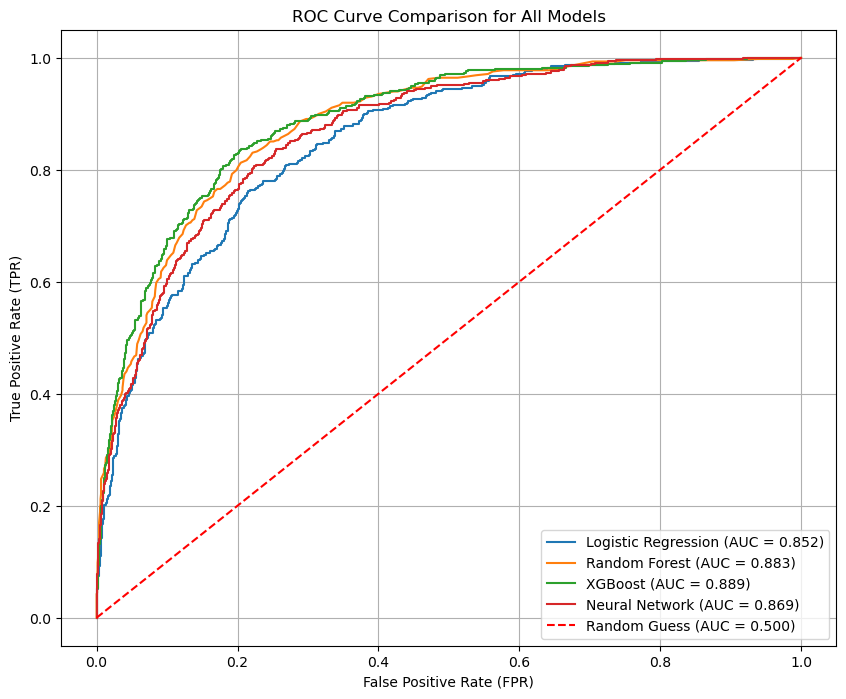

In [39]:
plt.figure(figsize=(10, 8))

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_score_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_score_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_score_xgb:.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_score_nn:.3f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess (AUC = 0.500)')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison for All Models')
plt.legend()
plt.grid(True)
plt.show()

### Model Comparison: ROC Curve and AUC

This plot visualizes the **Receiver Operating Characteristic (ROC)** curve for all four of my models. It gives me a comprehensive measure of their ability to distinguish between the 'No Rain' and 'Yes Rain' classes.

The key metric here is the **Area Under the Curve (AUC)**. An AUC of 1.0 is a perfect classifier, while 0.500 (the dashed red line) is just a random guess.

My findings from this chart are:

1.  **XGBoost is the Best Discriminator:** With an **AUC of 0.889**, my XGBoost model has the best overall ability to separate rainy from non-rainy days across all probability thresholds. Its curve is the most "bowed" toward the top-left corner.

2.  **Random Forest is a Close Second:** My Random Forest model also performed exceptionally well, with an **AUC of 0.883**.

3.  **Performance Tiers Confirmed:** This chart reinforces my findings from the F1-score comparison. The tree-based models (XGBoost and RF) are in the top tier. The **Neural Network (AUC = 0.869)** and **Logistic Regression (AUC = 0.852)**, while still effective, form a second, lower-performing tier.

4.  **Overall Model Success:** All four of my models demonstrated strong predictive power, as their AUC scores are all well above 0.85, confirming they are all viable for this task.

## Final Conclusion

This project was a success! I was able to develop and evaluate four different machine learning models to predict next-day rainfall in the Melbourne area, a task that was made challenging by a significant 76/24 class imbalance.

I'm happy with the methodology I used: a `scikit-learn` **`Pipeline`** to systematically apply `StandardScaler` and `OneHotEncoder`, with **SMOTE** integrated directly into the pipeline to prevent data leakage. Using `GridSearchCV` to tune each model by optimizing for the **F1-score** (rather than accuracy) was definitely the right call.

My final comparison of the models on the unseen test set yielded a clear winner:

* The **XGBoost Classifier** was my top-performing model. It achieved the highest **F1-score (0.660)** and the highest **AUC (0.889)**.
* The **Random Forest** classifier was a very close second, with an F1-score of **0.652** and an AUC of **0.883**.
* The **Keras Neural Network** (F1: 0.641, AUC: 0.869) and **Logistic Regression** (F1: 0.618, AUC: 0.852) were also effective, but ultimately less balanced and less discriminatory than the tree-based methods.

For this specific tabular, imbalanced dataset, I found that the tree-based ensemble methods—particularly XGBoost—proved to be the most effective solution. They provided the best balance of precision and recall for the difficult task of correctly predicting the minority class (rain).